In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Reading the datasets from the directory**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Nowa sekcja

In [ ]:
data = pd.read_csv("/content/dataset/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


**Information Extraction from keywords given to the patients after diagnosed**

In [ ]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

Attaching labels based whether cataract is present on which eye (left/right)

In [ ]:
def process_dataset(data):
    #create 2 more columns labelling them whether right or left eye has condition
    data["LC"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["RC"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))

    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))

    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))

    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.LC == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.RC == 1)]["Right-Fundus"].values

    #store the left/right normal image ids in a array
    left_normal = data.loc[(data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(400,random_state=42).values
    right_normal = data.loc[(data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(400,random_state=42).values

    #store the left/right diabetes image ids
    left_diab = data.loc[(data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.RD == 1)]["Right-Fundus"].values

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.RG == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.RH == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.RM == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_age = data.loc[(data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.RA == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_other = data.loc[(data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.RO == 1)]["Right-Fundus"].values

    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    # normalones = np.unique(normalones);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    # cataractones = np.unique(cataractones);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    # diabones = np.unique(diabones);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    # glaucoma = np.unique(glaucoma);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    # hyper = np.unique(hyper);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    # myopia = np.unique(myopia);
    age = np.concatenate((left_age,right_age),axis=0);
    # age = np.unique(age);
    other = np.concatenate((left_other,right_other),axis = 0);
    # other = np.unique(other);

    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [ ]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))

Dataset stats::
Normal :: 800
Cataract :: 594
Diabetes :: 1877
Glaucoma :: 616
Hypertension :: 382
Myopia :: 479
Age Issues :: 551
Other :: 336


**Generating Dataset**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/dataset/preprocessed_images"
image_size=224
labels = []
dataset = []

def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);

    return dataset;

In [ ]:
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)

100%|██████████| 336/336 [00:01<00:00, 278.76it/s]


5580

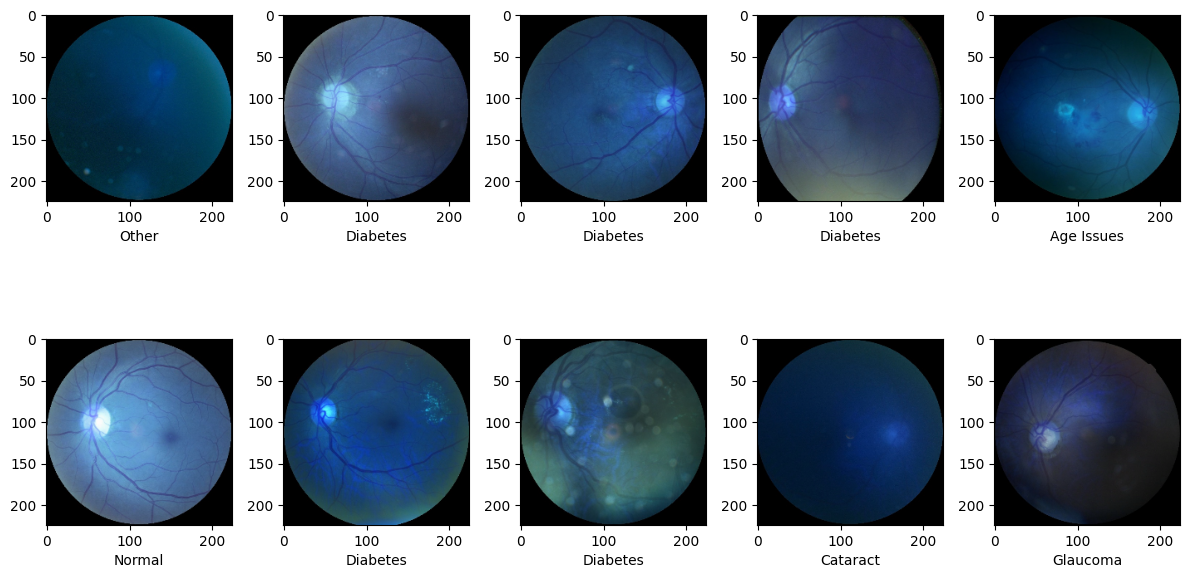

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

**Splitting the dataset**

In [ ]:
train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

y_train_cat = to_categorical(y_train,num_classes=8)
y_test_cat = to_categorical(y_test,num_classes = 8)
y_val_cat = to_categorical(y_val,num_classes = 8)


Creating the model

Badam optimizer: adam  dla aktywacji: relu
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 224, 224, 16)      2368      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_poolin

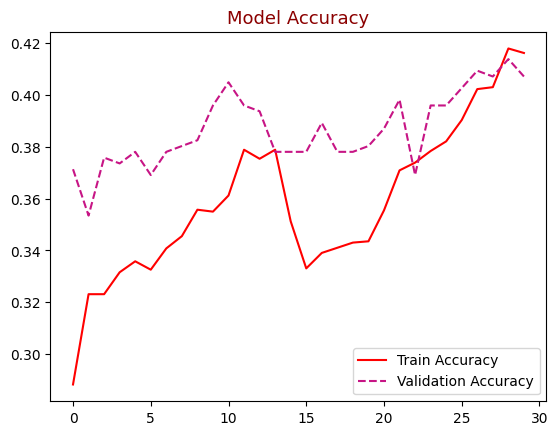

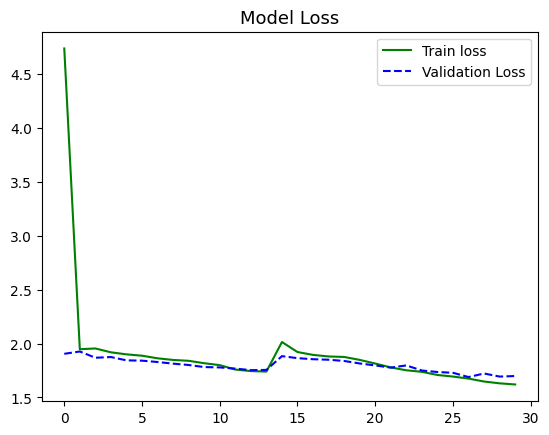

35/35 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

      Normal       0.33      0.09      0.14       148
    Cataract       0.69      0.19      0.30       113
    Diabetes       0.39      0.92      0.55       373
    Glaucoma       0.43      0.37      0.40       115
Hypertension       0.52      0.13      0.21        83
      Myopia       0.60      0.16      0.25        94
        ARMD       0.38      0.02      0.05       122
       Other       0.50      0.01      0.03        68

    accuracy                           0.41      1116
   macro avg       0.48      0.24      0.24      1116
weighted avg       0.45      0.41      0.32      1116

Suma f1 score:  1.9261832077540657
Średnia f1 score:  0.2407729009692582


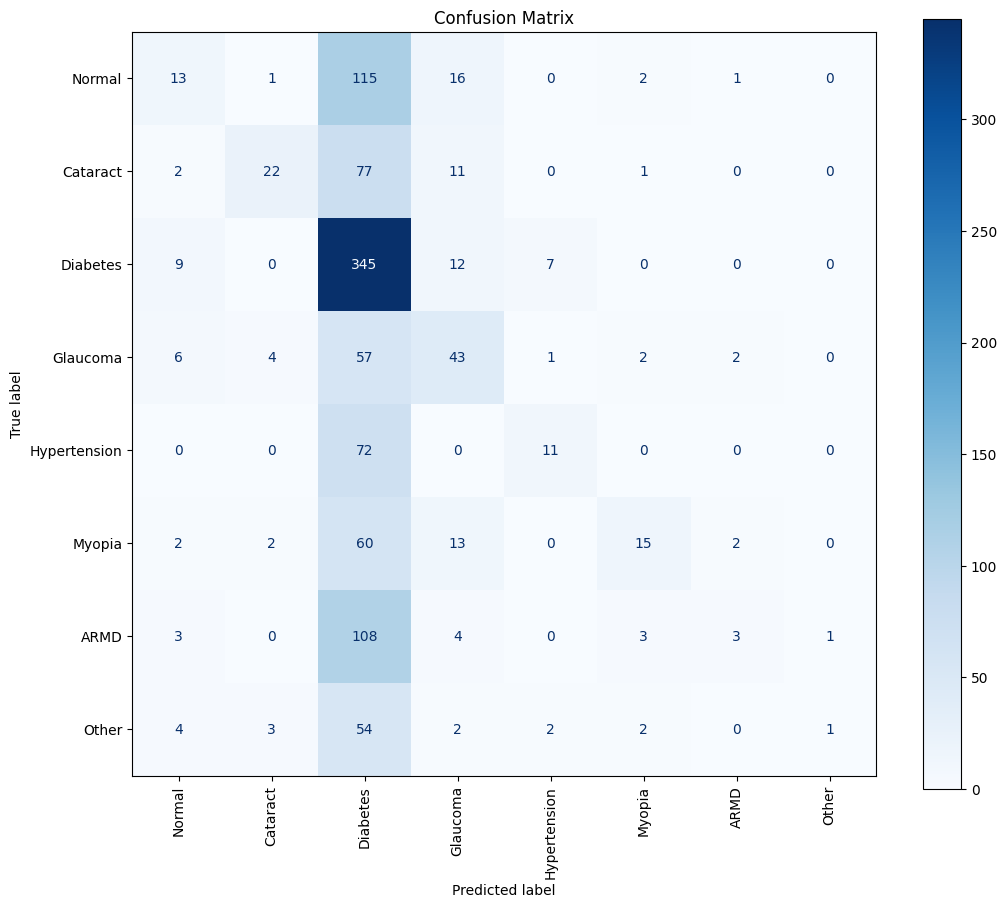

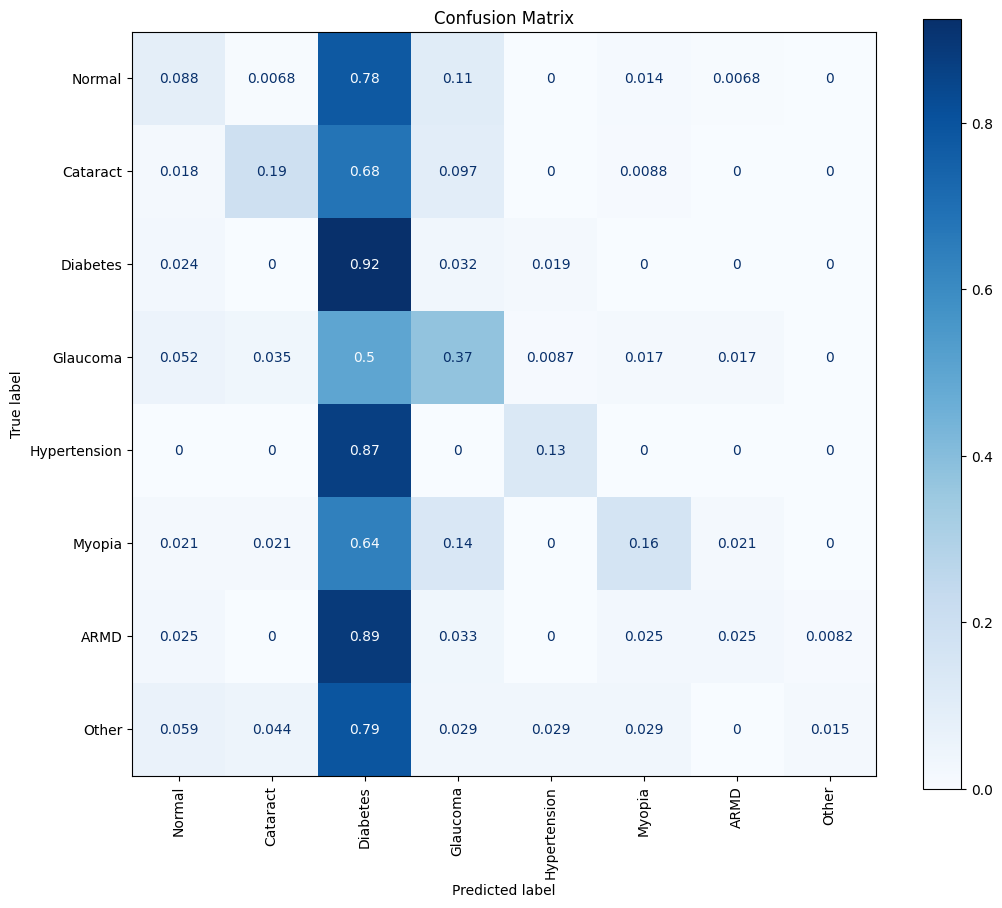

Badam optimizer: SGD  dla aktywacji: relu
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 16)      2368      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_poolin

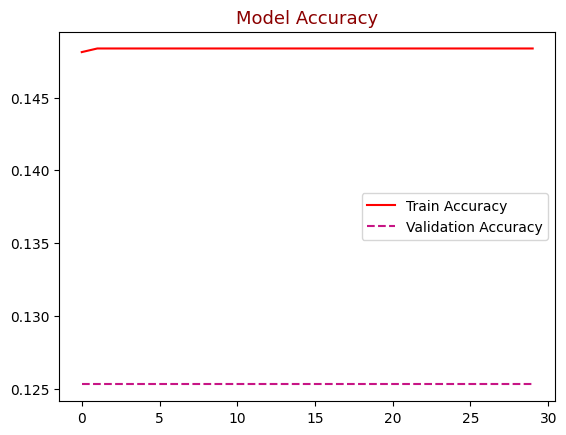

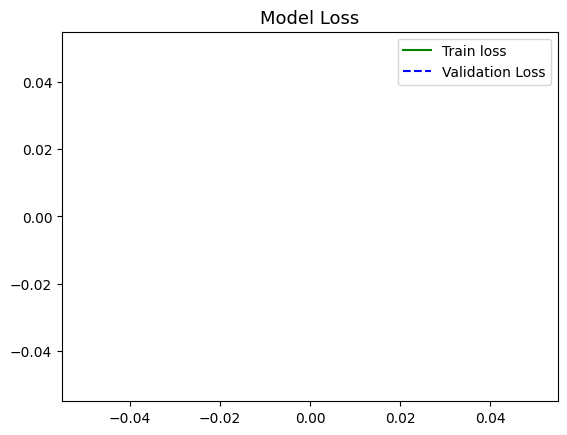

35/35 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

      Normal       0.13      1.00      0.23       148
    Cataract       0.00      0.00      0.00       113
    Diabetes       0.00      0.00      0.00       373
    Glaucoma       0.00      0.00      0.00       115
Hypertension       0.00      0.00      0.00        83
      Myopia       0.00      0.00      0.00        94
        ARMD       0.00      0.00      0.00       122
       Other       0.00      0.00      0.00        68

    accuracy                           0.13      1116
   macro avg       0.02      0.12      0.03      1116
weighted avg       0.02      0.13      0.03      1116

Suma f1 score:  0.23417721518987342
Średnia f1 score:  0.029272151898734177


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

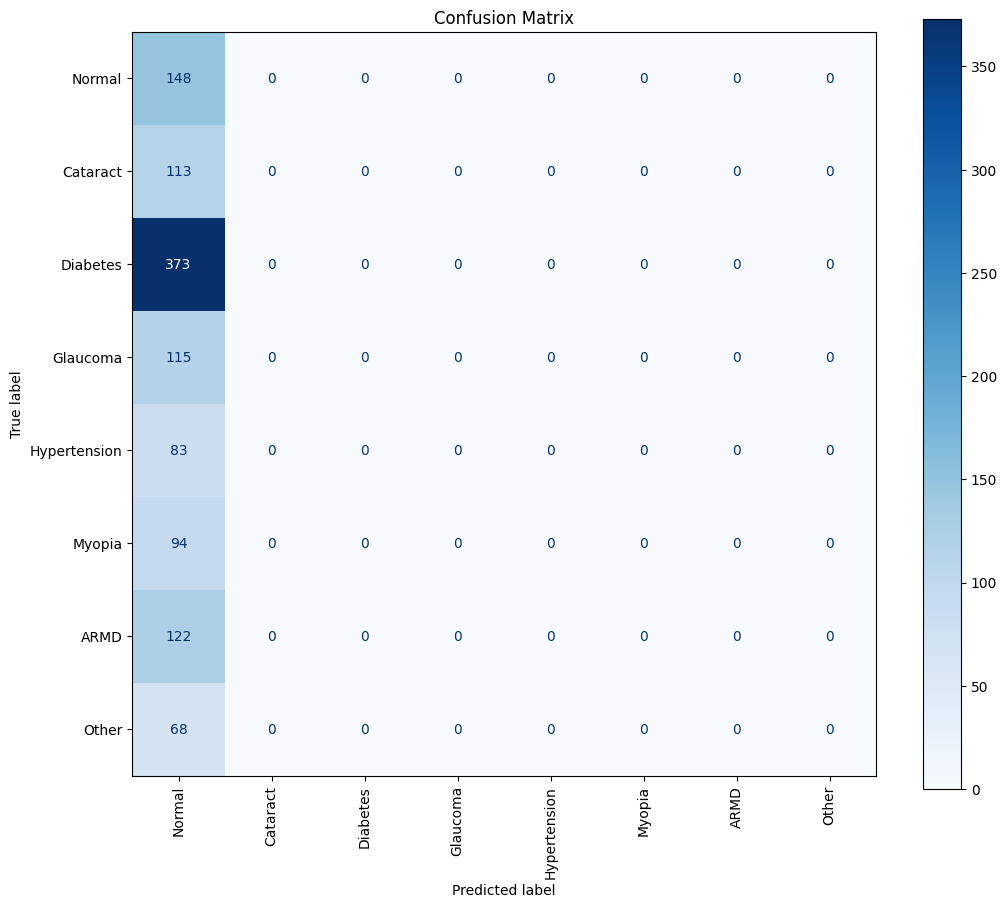

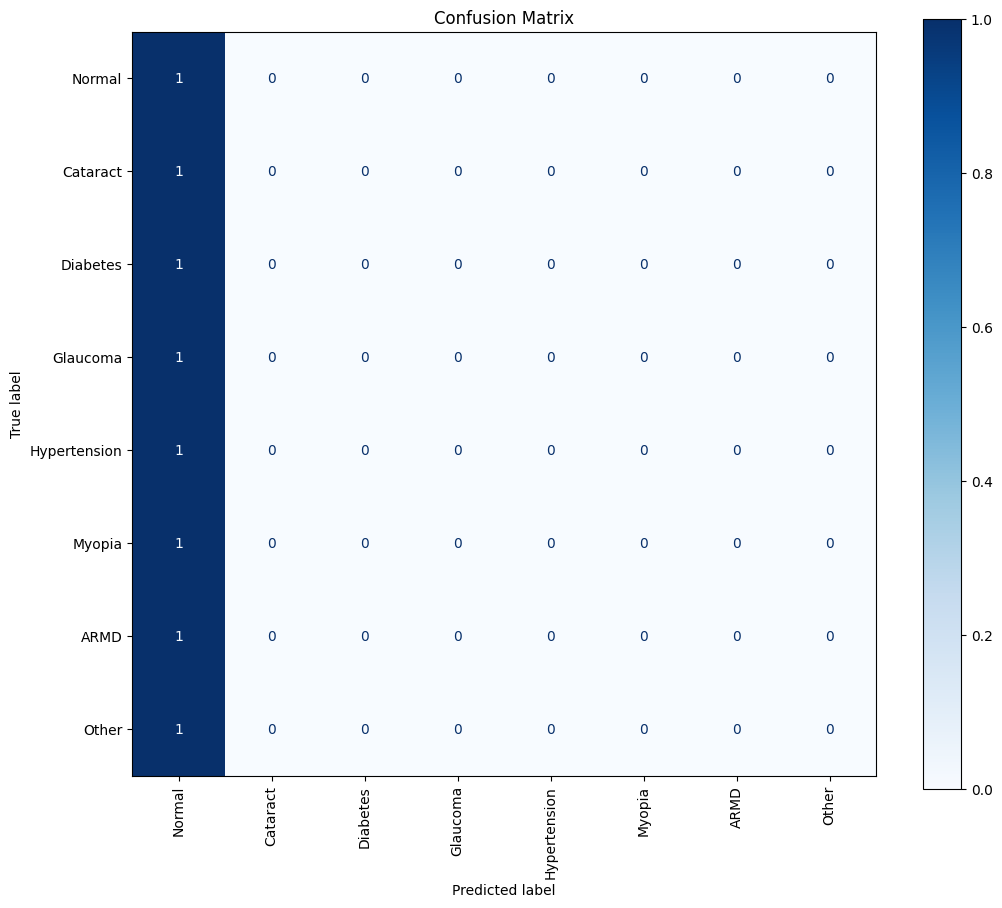

Badam optimizer: adam  dla aktywacji: tanh
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 16)      2368      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_42 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooli

KeyboardInterrupt: 

In [ ]:
import pickle
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
import os
import random
import shutil
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import pandas as pd
import numpy as np
import itertools
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


# Normal (N),
# Diabetes (D),
# Glaucoma (G), jaskra
# Cataract (C), zaćma
# Age related Macular Degeneration (A), Zwyrodnienie plamki żółtej związane z wiekiem
# Hypertension (H),
# Pathological Myopia (M), krótkowzroczność
# Other diseases/abnormalities (O)

def create_model(filters, activation, optimizer):
    # ************** Model *********************
    model = Sequential()
    model.add(Conv2D(filters, 7, activation=activation, input_shape=(224, 224, 3), padding="same"))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters * 2, 3, activation=activation, padding="same"))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters * 4, 3, activation=activation, padding="same"))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters * 8, 3, activation=activation, padding="same"))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def plot_accuracy_and_loss(history):
    # Plot train & validation accuracy
    plt.figure()
    plt.plot(history.history["accuracy"],
             label="Train Accuracy",
             color="red")
    plt.plot(history.history["val_accuracy"],
             label="Validation Accuracy",
             color="mediumvioletred",
             linestyle="dashed",
             markeredgecolor="blue",
             markeredgewidth=2)
    plt.title("Model Accuracy", color="darkred", size=13)
    plt.legend()
    plt.show()

    # Plot train & validation loss
    plt.figure()
    plt.plot(history.history["loss"],
             label="Train loss",
             color="green")
    plt.plot(history.history["val_loss"],
             label="Validation Loss",
             color="blue",
             linestyle="dashed",
             markeredgecolor="blue",
             markeredgewidth=2)
    plt.title("Model Loss", color="black", size=13)
    plt.legend()
    plt.show()

def fit_and_plot(model, batch_size, epochs):
    # ************** Uczenie *********************
    history = model.fit(
        x_train,
        y_train_cat,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val_cat))
    plot_accuracy_and_loss(history)
    loss,accuracy = model.evaluate(x_test,y_test_cat)
    return accuracy, model, loss

def make_classification_report(model):
    y_pred = []
    for i in model.predict(x_test):
      y_pred.append(np.argmax(np.array(i)).astype("int32"))
    report = classification_report(y_test, y_pred, target_names=["Normal","Cataract","Diabetes","Glaucoma","Hypertension","Myopia","ARMD","Other"])
    print(report)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    print('Suma f1 score: ', sum(f1))
    print('Średnia f1 score: ', sum(f1)/len(f1))
    plot_confusion_matrix(y_test, y_pred, classes=["Normal","Cataract","Diabetes","Glaucoma","Hypertension","Myopia","ARMD","Other"])

def plot_confusion_matrix(true, pred, classes):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=true,
        y_pred=pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        xticks_rotation='vertical'
    )
    disp.ax_.set_title("Confusion Matrix")
    disp.figure_.set_figheight(10)
    disp.figure_.set_figwidth(12)
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_true=true,
        y_pred=pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize='true',
        xticks_rotation='vertical'
    )
    disp2.ax_.set_title("Confusion Matrix")
    disp2.figure_.set_figheight(10)
    disp2.figure_.set_figwidth(12)
    plt.show()

# ************** Parametry *********************
activation_values = ['relu', 'tanh']
optimizer_values = ['adam', 'SGD']


# ************** Uczenie i prezentacja wyników *********************
for activation in activation_values:
  for optimizer in optimizer_values:
    print('Badam optimizer: ' + str(optimizer),  ' dla aktywacji: ' + str(activation))
    model = create_model(16, activation, optimizer)
    accuracy, model, loss = fit_and_plot(model=model, batch_size=64, epochs=30)
    make_classification_report(model)
